In [80]:
import pandas as pd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.community import modularity_max
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import csv
import json
import seaborn as sns

from itertools import product
from sklearn.metrics.pairwise import euclidean_distances

This notebook explores alternative way of creating an ecological network by considering some threats that are related to ecology.

For the encodig, a LabelEncoder is used and then the data is normalized.

# EDA

In [81]:
df = pd.read_csv('Psittaciformes.csv')

In [82]:
basic_columns_list = [
    'scientificName',
    'familyName',
    'orderName',

    'Beak.Length_Culmen',
    'Beak.Length_Nares',
    'Beak.Width',
    'Beak.Depth',
    'Tarsus.Length',
    'Wing.Length',
    'Kipps.Distance',
    'Hand-Wing.Index',
    'Tail.Length',
    'Mass',

    'Habitat',
    'Habitat.Density',
    'Migration',
    'Trophic.Level',
    'Trophic.Niche',
    'Primary.Lifestyle',

    'Min.Latitude',
    'Max.Latitude',
    'Centroid.Latitude',
    'Centroid.Longitude',
    'Range.Size',


    'redlistCategory',
    'populationTrend',
    'threats'


]

df = df[basic_columns_list]

In [83]:
Ecological_features = [
    'Habitat',
    'Trophic.Level',
    'Trophic.Niche',
    'Primary.Lifestyle',
    'Habitat.Density',
    'Migration',
    'threats'
]

In [84]:
df[Ecological_features]

,Habitat,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Habitat.Density,Migration,threats
0,Forest,Herbivore,Frugivore,Insessorial,2,1.0,Trade represents a significant and on-going th...
1,Forest,Herbivore,Nectarivore,Insessorial,1,1.0,NaN
2,Forest,Herbivore,Nectarivore,Insessorial,1,1.0,Its preferred habitat is relatively unlikely t...
3,Forest,Herbivore,Nectarivore,Insessorial,2,1.0,NaN
4,Forest,Herbivore,Nectarivore,Insessorial,1,1.0,"Avian malaria, cyclones and natural cycles are..."
...,...,...,...,...,...,...,...
396,Woodland,Herbivore,Granivore,Terrestrial,3,1.0,NaN
397,Forest,Herbivore,Frugivore,Insessorial,1,1.0,NaN
398,Forest,Herbivore,Granivore,Generalist,2,1.0,NaN
399,Forest,Herbivore,Granivore,Insessorial,1,1.0,NaN


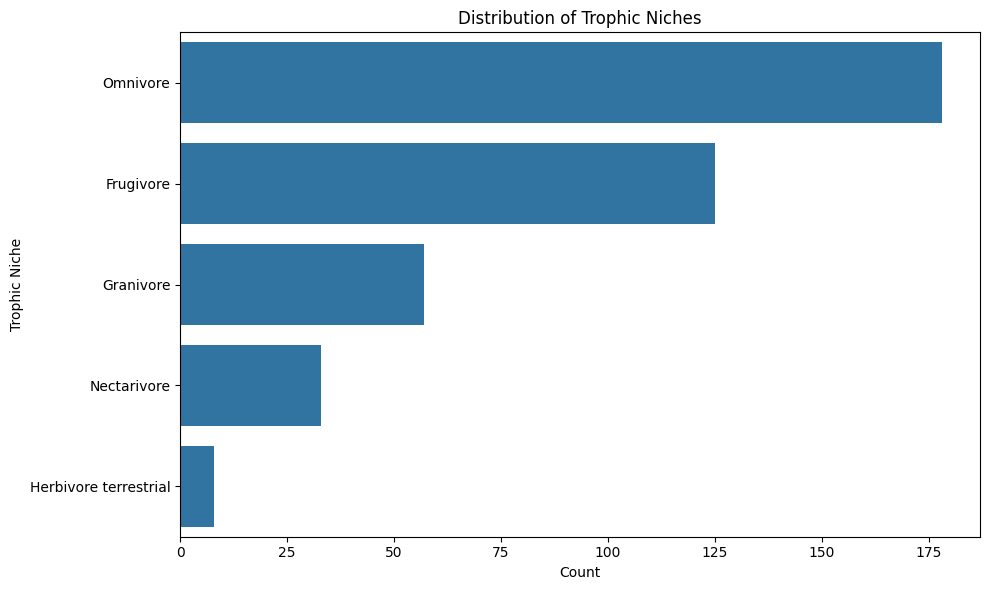

In [85]:
import seaborn as sns

# Create the plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Trophic.Niche', order=df['Trophic.Niche'].value_counts().index)

# Customize
plt.xlabel('Count')
plt.ylabel('Trophic Niche')
plt.title('Distribution of Trophic Niches')

plt.tight_layout()
plt.show()

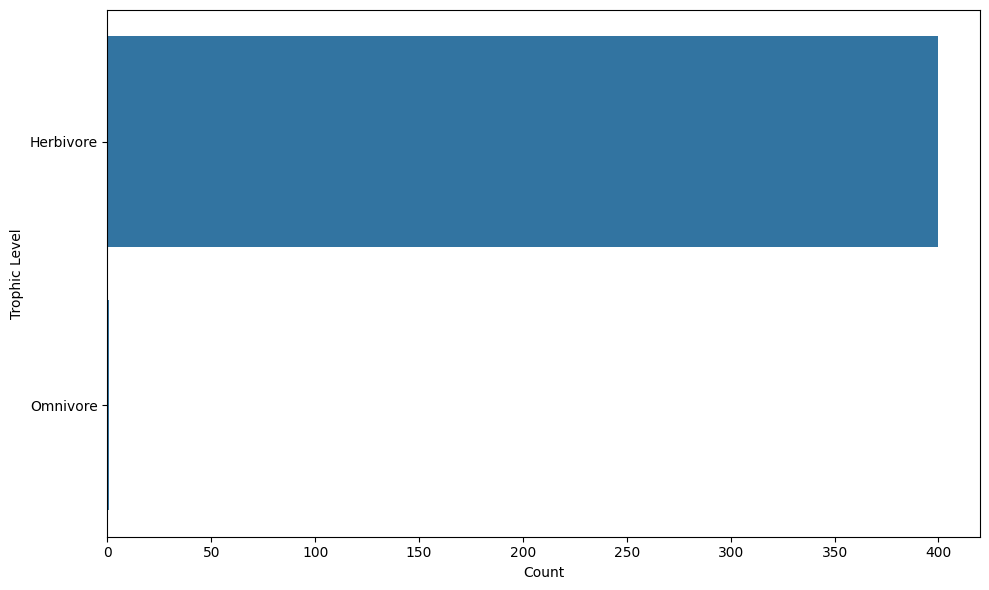

In [86]:


plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Trophic.Level',
              order=df['Trophic.Level'].value_counts().index,
              )

plt.xlabel('Count')
plt.ylabel('Trophic Level')
plt.tight_layout()
plt.show()

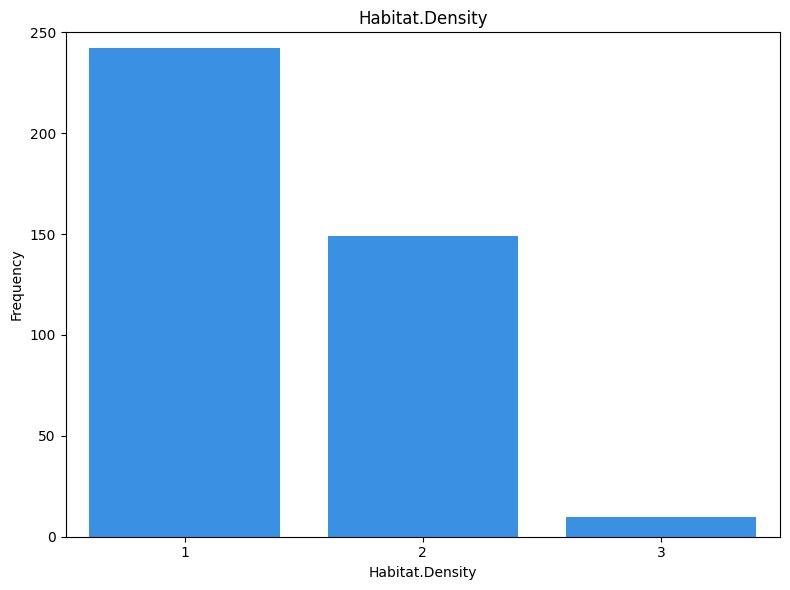

In [87]:


plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Habitat.Density', color='dodgerblue')

plt.title('Habitat.Density')
plt.xlabel('Habitat.Density')
plt.ylabel('Frequency')
plt.ylim(0, 250)

plt.tight_layout()
plt.show()

<ipython-input-88-03976ea91869>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,


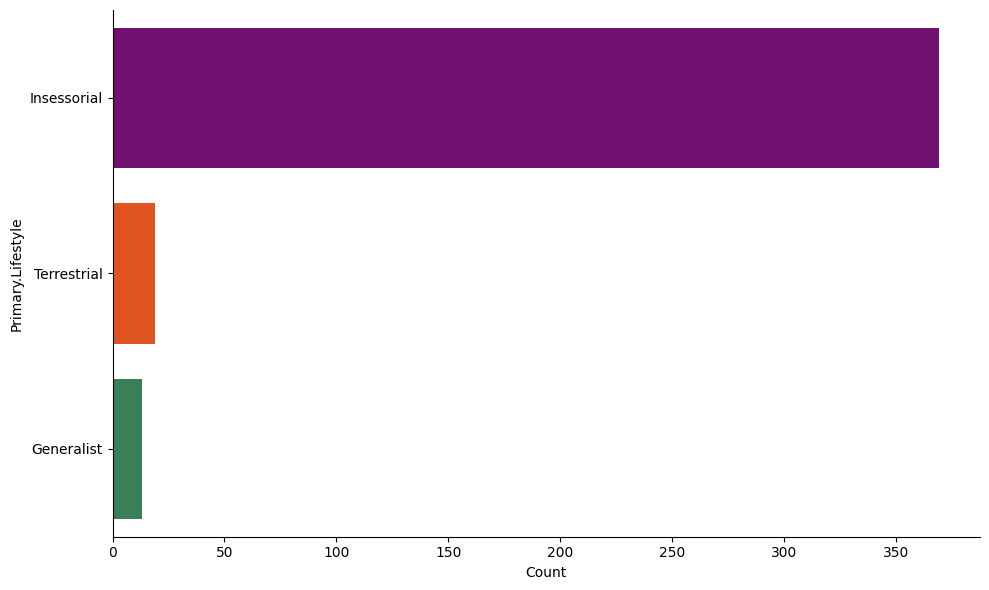

In [88]:


plt.figure(figsize=(10, 6))
sns.countplot(data=df,
              y='Primary.Lifestyle',
              order=df['Primary.Lifestyle'].value_counts().index,
              palette=['purple', 'orangered', 'seagreen'])

plt.xlabel('Count')
plt.ylabel('Primary.Lifestyle')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

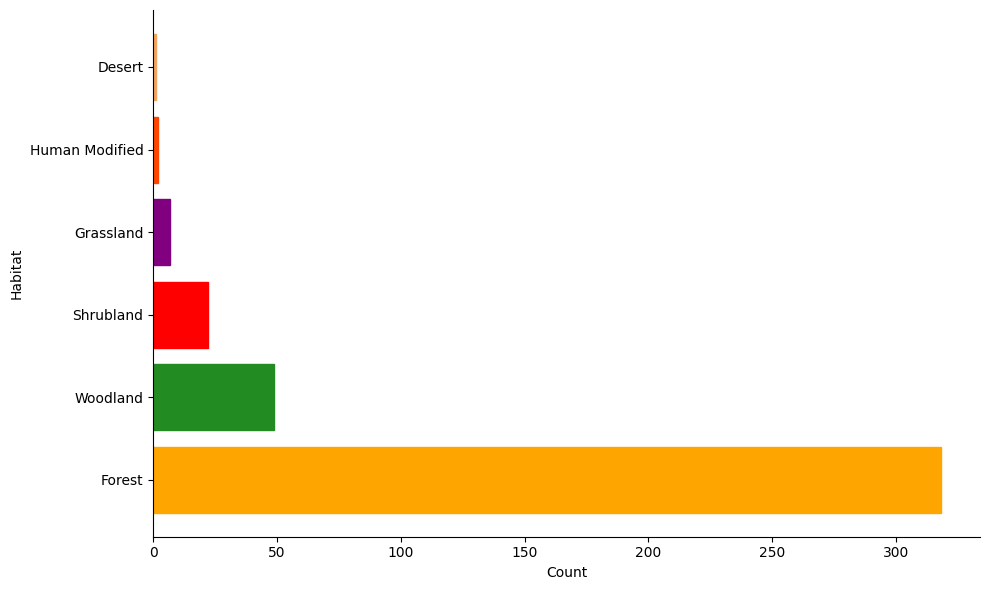

In [89]:

# Count frequencies of Habitat
habitat_counts = df['Habitat'].value_counts()

# Create the plot
plt.figure(figsize=(10, 6))

# Define colors for each habitat type
colors = ['orange', 'forestgreen', 'red', 'purple', 'orangered', 'sandybrown']

# Create horizontal bars
bars = plt.barh(y=habitat_counts.index, width=habitat_counts.values)

# Apply colors to bars
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Customize the plot
plt.xlabel('Count')
plt.ylabel('Habitat')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Creating the Network

In [111]:
species_names = df['scientificName'].values

In [112]:
# Define categories and their keywords
categories = {
    'Trade': ["trade"],
    'Habitat Loss': ["habitat", "loss", "forest", "areas"],
    'Climate Change': ["cyclones", "natural", "climate"],
    'Diseases': ["avian", "malaria"],
    'Predation': ["predators"],
    'Human Activity': ["hunting", "logging", "agriculture"],
    'Pollution': ["pollution"],
}

def categorize_threat(threat, category_keywords):
    if not isinstance(threat, str):
        return []
    return [cat for cat, keywords in category_keywords.items()
            if any(keyword in threat.lower() for keyword in keywords)]

# Create a new column for threat categories
df['threat_categories'] = df.apply(
    lambda row: json.dumps(categorize_threat(row.get('threats', ''), categories)),
    axis=1
)

# If you want to create separate boolean columns for each category
for category in categories.keys():
    df[f'threat_{category.lower().replace(" ", "_")}'] = df['threat_categories'].apply(
        lambda x: category in json.loads(x)
    )

# Optional: If you want to count threats per species
df['num_threats'] = df['threat_categories'].apply(lambda x: len(json.loads(x)))



In [113]:
Ecological_features = [
    'Habitat',
    'Trophic.Level',
    'Trophic.Niche',
    'Primary.Lifestyle',
    'Habitat.Density',
    'Migration',
    'threat_habitat_loss',
    'threat_climate_change',
    'threat_diseases',
    'threat_predation',
    'threat_human_activity',
    'threat_pollution',
    'num_threats'
]

In [114]:
df[Ecological_features]

,Habitat,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Habitat.Density,Migration,threat_habitat_loss,threat_climate_change,threat_diseases,threat_predation,threat_human_activity,threat_pollution,num_threats
0,Forest,Herbivore,Frugivore,Insessorial,2,1.0,True,False,False,False,True,False,3
1,Forest,Herbivore,Nectarivore,Insessorial,1,1.0,False,False,False,False,False,False,0
2,Forest,Herbivore,Nectarivore,Insessorial,1,1.0,True,True,False,False,True,False,3
3,Forest,Herbivore,Nectarivore,Insessorial,2,1.0,False,False,False,False,False,False,0
4,Forest,Herbivore,Nectarivore,Insessorial,1,1.0,True,True,True,False,True,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,Woodland,Herbivore,Granivore,Terrestrial,3,1.0,False,False,False,False,False,False,0
397,Forest,Herbivore,Frugivore,Insessorial,1,1.0,False,False,False,False,False,False,0
398,Forest,Herbivore,Granivore,Generalist,2,1.0,False,False,False,False,False,False,0
399,Forest,Herbivore,Granivore,Insessorial,1,1.0,False,False,False,False,False,False,0


In [115]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_ecological_features(df):
    """
    Encode ecological features using label encoding
    """
    # Create a copy of the dataframe
    df_encoded = df.copy()

    # Categorical columns to encode
    categorical_columns = ['Habitat', 'Trophic.Level', 'Trophic.Niche', 'Primary.Lifestyle']

    # Initialize dictionary to store encoders
    encoders = {}

    # Encode each categorical column
    for column in categorical_columns:
        le = LabelEncoder()
        df_encoded[column] = le.fit_transform(df[column].astype(str))
        encoders[column] = le

    # Handle threat columns - convert boolean/string to numeric
    threat_columns = [col for col in df.columns if col.startswith('threat_')]
    for col in threat_columns:
        df_encoded[col] = df_encoded[col].map({'true': 1, 'false': 0, True: 1, False: 0})

    # Keep numeric columns as they are
    numeric_columns = ['Habitat.Density', 'Migration']

    return df_encoded, encoders

# Use the function
df_encoded, encoders = encode_ecological_features(df)



In [116]:
# Print mappings
for column, encoder in encoders.items():
    print(f"\n{column} mappings:")
    for i, label in enumerate(encoder.classes_):
        print(f"{label} -> {i}")



Habitat mappings:
Desert -> 0
Forest -> 1
Grassland -> 2
Human Modified -> 3
Shrubland -> 4
Woodland -> 5
nan -> 6

Trophic.Level mappings:
Herbivore -> 0
Omnivore -> 1

Trophic.Niche mappings:
Frugivore -> 0
Granivore -> 1
Herbivore terrestrial -> 2
Nectarivore -> 3
Omnivore -> 4

Primary.Lifestyle mappings:
Generalist -> 0
Insessorial -> 1
Terrestrial -> 2


In [117]:
df_encoded[Ecological_features].head()

,Habitat,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Habitat.Density,Migration,threat_habitat_loss,threat_climate_change,threat_diseases,threat_predation,threat_human_activity,threat_pollution,num_threats
0,1,0,0,1,2,1.0,1,0,0,0,1,0,3
1,1,0,3,1,1,1.0,0,0,0,0,0,0,0
2,1,0,3,1,1,1.0,1,1,0,0,1,0,3
3,1,0,3,1,2,1.0,0,0,0,0,0,0,0
4,1,0,3,1,1,1.0,1,1,1,0,1,0,4


In [118]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt

# Select all columns except 'species_names'
columns_to_normalize = Ecological_features

# Create a new dataframe with only the numeric columns
df_numeric = df_encoded[columns_to_normalize]

# Normalize
scaler = StandardScaler()
X_normalized = pd.DataFrame(
    scaler.fit_transform(df_numeric),
    columns=columns_to_normalize,
    index=df_encoded.index
)

#Fill NaN values with mean
X_normalized = X_normalized.fillna(X_normalized.mean())

# Verify the shape
print("Shape of X_normalized:", X_normalized.shape)




Shape of X_normalized: (401, 13)


In [119]:
X_normalized.head()

,Habitat,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Habitat.Density,Migration,threat_habitat_loss,threat_climate_change,threat_diseases,threat_predation,threat_human_activity,threat_pollution,num_threats
0,-0.483112,-0.05,-1.231372,-0.053041,1.067550,-0.211911,1.007509,-0.359969,-0.142675,-0.190199,1.586677,-0.070799,1.185881
1,-0.483112,-0.05,0.444353,-0.053041,-0.777655,-0.211911,-0.992546,-0.359969,-0.142675,-0.190199,-0.630248,-0.070799,-0.969126
2,-0.483112,-0.05,0.444353,-0.053041,-0.777655,-0.211911,1.007509,2.778019,-0.142675,-0.190199,1.586677,-0.070799,1.185881
3,-0.483112,-0.05,0.444353,-0.053041,1.067550,-0.211911,-0.992546,-0.359969,-0.142675,-0.190199,-0.630248,-0.070799,-0.969126
4,-0.483112,-0.05,0.444353,-0.053041,-0.777655,-0.211911,1.007509,2.778019,7.008923,-0.190199,1.586677,-0.070799,1.904217


In [120]:
species_names = df['scientificName'].values

In [121]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity_matrix(df,spe):
    """
    Compute similarity matrix from encoded ecological features

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing encoded ecological features

    Returns:
    --------
    similarity_df : pandas DataFrame
        Similarity matrix with species names as index and columns
    """



    similarity_matrix = cosine_similarity(df)

    # Create DataFrame with species names
    similarity_df = pd.DataFrame(similarity_matrix,
                               index=species_names,
                               columns=species_names)

    return similarity_df

In [122]:
similarity_df=compute_similarity_matrix(X_normalized,species_names)

In [123]:
similarity_df

,Eos histrio,Trichoglossus euteles,Trichoglossus johnstoniae,Vini australis,Charmosyna palmarum,Prioniturus mada,Agapornis nigrigenis,Loriculus galgulus,Loriculus catamene,Nicopsitta calthrapae,...,Deroptyus accipitrinus,Loriculus stigmatus,Poicephalus flavifrons,Poicephalus crassus,Poicephalus gulielmi,Agapornis pullarius,Amazona mercenarius,Agapornis taranta,Cyclopsitta nigrifrons,Poicephalus rueppellii
Eos histrio,1.000000,-0.751916,0.275412,-0.360501,0.119444,-0.315661,0.356687,-0.199034,-0.349380,-0.002803,...,-0.315661,-0.794797,-0.438617,-0.118703,-0.728377,-0.016533,-0.315661,-0.043833,-0.479912,-0.494074
Trichoglossus euteles,-0.751916,1.000000,-0.425931,0.560990,-0.308214,0.678440,-0.606171,0.565836,0.325579,0.320347,...,0.678440,0.965964,0.571915,0.419520,0.883895,-0.126020,0.678440,0.234916,0.833018,0.278248
Trichoglossus johnstoniae,0.275412,-0.425931,1.000000,-0.587384,0.454757,-0.454743,0.529691,-0.387574,0.016151,-0.597264,...,-0.454743,-0.353064,-0.507144,-0.633828,-0.272429,-0.395269,-0.454743,-0.306793,-0.479648,-0.520101
Vini australis,-0.360501,0.560990,-0.587384,1.000000,-0.375036,0.314738,-0.400995,0.176855,-0.070259,0.713845,...,0.314738,0.565086,0.969474,0.853936,0.449097,0.374853,0.314738,0.451925,0.417718,0.620758
Charmosyna palmarum,0.119444,-0.308214,0.454757,-0.375036,1.000000,-0.305271,0.251172,-0.252431,-0.071400,-0.366058,...,-0.305271,-0.263862,-0.329157,-0.393331,-0.204589,-0.221593,-0.305271,-0.192332,-0.329168,-0.318722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Agapornis pullarius,-0.016533,-0.126020,-0.395269,0.374853,-0.221593,-0.013098,-0.272414,-0.078958,-0.428485,0.416324,...,-0.013098,-0.147223,0.311334,0.430624,-0.233497,1.000000,-0.013098,-0.337178,-0.050456,0.582044
Amazona mercenarius,-0.315661,0.678440,-0.454743,0.314738,-0.305271,1.000000,-0.432182,0.946941,-0.123135,0.672552,...,1.000000,0.465309,0.148318,0.601573,0.352780,-0.013098,1.000000,0.323086,0.971598,-0.044462
Agapornis taranta,-0.043833,0.234916,-0.306793,0.451925,-0.192332,0.323086,0.355298,0.273214,-0.153005,0.509471,...,0.323086,0.169277,0.372704,0.524771,0.100126,-0.337178,0.323086,1.000000,0.318974,0.219674
Cyclopsitta nigrifrons,-0.479912,0.833018,-0.479648,0.417718,-0.329168,0.971598,-0.520714,0.895370,0.012143,0.609663,...,0.971598,0.661553,0.295911,0.588155,0.550376,-0.050456,0.971598,0.318974,1.000000,0.056143



Normalized Similarity Statistics:
Mean similarity: 0.485
Similarity range: 0.000 to 1.000

Distance Statistics:
Mean distance: 0.515
Distance range: 0.000 to 1.000

Ecological Interpretation:
Moderate ecological differentiation between species


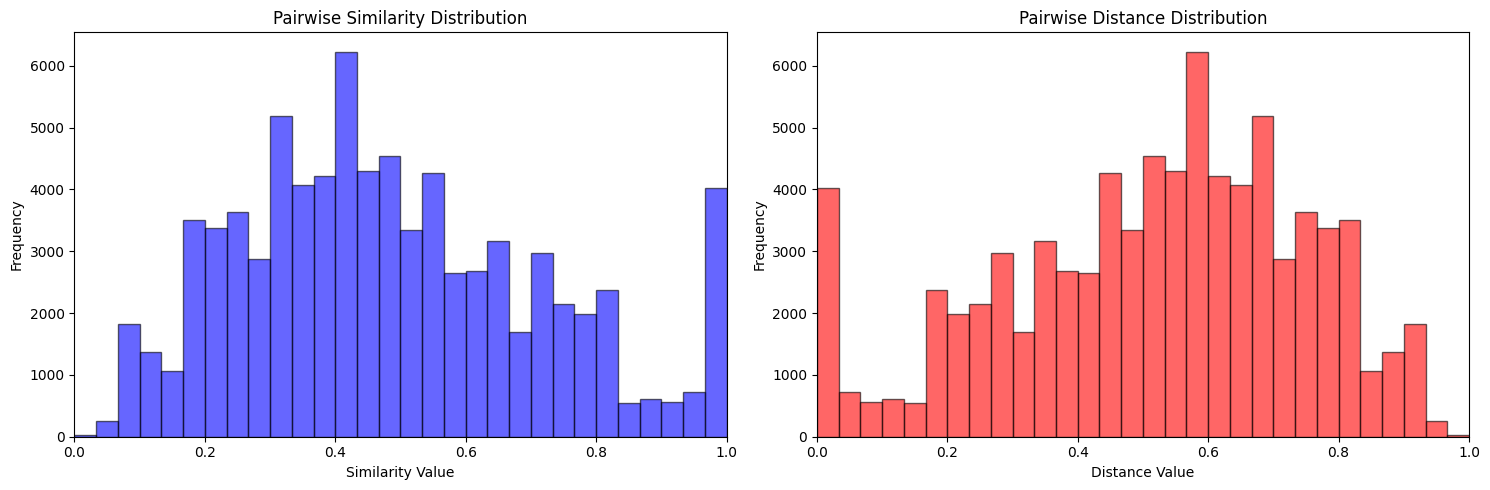

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_similarity_and_distance_distribution(similarity_matrix):
    # Convert pandas DataFrame to numpy array if needed
    if isinstance(similarity_matrix, pd.DataFrame):
        similarity_array = similarity_matrix.to_numpy()
    else:
        similarity_array = similarity_matrix

    # Get upper triangle values (excluding diagonal)
    mask = np.triu_indices(similarity_array.shape[0], k=1)
    similarities = similarity_array[mask]

    # Normalize similarities to [0,1] range first if needed
    similarities_normalized = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))

    # Convert to distances (1 - normalized similarity)
    distances = 1 - similarities_normalized

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Similarity Histogram
    ax1.hist(similarities_normalized, bins=30, edgecolor='black', color='blue', alpha=0.6)
    ax1.set_title('Pairwise Similarity Distribution')
    ax1.set_xlabel('Similarity Value')
    ax1.set_ylabel('Frequency')
    ax1.set_xlim(0, 1)

    # Distance Histogram
    ax2.hist(distances, bins=30, edgecolor='black', color='red', alpha=0.6)
    ax2.set_title('Pairwise Distance Distribution')
    ax2.set_xlabel('Distance Value')
    ax2.set_ylabel('Frequency')
    ax2.set_xlim(0, 1)

    plt.tight_layout()

    # Print statistics
    print("\nNormalized Similarity Statistics:")
    print(f"Mean similarity: {np.mean(similarities_normalized):.3f}")
    print(f"Similarity range: {np.min(similarities_normalized):.3f} to {np.max(similarities_normalized):.3f}")

    print("\nDistance Statistics:")
    print(f"Mean distance: {np.mean(distances):.3f}")
    print(f"Distance range: {np.min(distances):.3f} to {np.max(distances):.3f}")

    # Ecological interpretation
    print("\nEcological Interpretation:")
    mean_dist = np.mean(distances)
    if mean_dist < 0.3:
        print("Species are generally very similar (small ecological distances)")
    elif mean_dist < 0.6:
        print("Moderate ecological differentiation between species")
    else:
        print("High ecological differentiation between species")

    if np.std(distances) > 0.25:
        print("High variance indicates potential distinct ecological groups")

    return {
        'similarity_stats': {
            'mean': np.mean(similarities_normalized),
            'median': np.median(similarities_normalized),
            'std': np.std(similarities_normalized),
            'min': np.min(similarities_normalized),
            'max': np.max(similarities_normalized)
        },
        'distance_stats': {
            'mean': np.mean(distances),
            'median': np.median(distances),
            'std': np.std(distances),
            'min': np.min(distances),
            'max': np.max(distances)
        }
    }

# Use the function
stats = plot_similarity_and_distance_distribution(similarity_df)

In [125]:
def create_knn_network(similarity_df, species_names, k=5, threshold=0.5):
    """
    Create KNN network from similarity matrix with threshold

    Parameters:
    -----------
    similarity_df : pandas DataFrame
        Similarity matrix
    species_names : list
        List of species names
    k : int
        Number of nearest neighbors
    threshold : float
        Minimum similarity threshold for edges (0 to 1)

    Returns:
    --------
    G : networkx Graph
        Thresholded KNN network
    """


    # Convert similarity matrix to numpy array
    similarity_matrix = similarity_df.values

    # Set diagonal to -inf to avoid self loops
    np.fill_diagonal(similarity_matrix, -np.inf)

    # Get indices of k nearest neighbors for each species
    nearest_neighbors = np.argsort(-similarity_matrix)[:, :k]

    # Create network
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(species_names)

    # Add edges based on KNN and threshold
    edge_count = 0
    filtered_count = 0

    for i, neighbors in enumerate(nearest_neighbors):
        species1 = species_names[i]
        for j in neighbors:
            species2 = species_names[j]
            similarity = similarity_matrix[i, j]

            # Only add edge if similarity exceeds threshold
            if similarity >= threshold:
                G.add_edge(species1, species2, weight=similarity)
                edge_count += 1
            else:
                filtered_count += 1

    # Remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Print statistics
    print(f"Total possible edges (k={k}): {len(species_names) * k}")
    print(f"Edges added (threshold={threshold}): {edge_count}")
    print(f"Edges filtered out: {filtered_count}")
    print(f"Average degree: {2 * edge_count / len(species_names):.2f}")

    return G


In [126]:
def analyze_knn_graph(G):
    """
    Analyze the KNN graph properties
    """
    results = {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'average_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'density': nx.density(G),
        'is_connected': nx.is_connected(G),
        "number_of_components": nx.number_connected_components(G),
        'connected_components': list(nx.connected_components(G)),
        'component_sizes': [len(c) for c in nx.connected_components(G)],

        'average_clustering': nx.average_clustering(G),
        'degree_centrality': nx.degree_centrality(G),
        'betweenness_centrality': nx.betweenness_centrality(G)
    }

    return results





In [127]:
G=create_knn_network(similarity_df, species_names, k=5, threshold=0.6)

Total possible edges (k=5): 2005
Edges added (threshold=0.6): 1990
Edges filtered out: 15
Average degree: 9.93


In [128]:


# Analyze graph properties
analysis = analyze_knn_graph(G)
print("\nGraph Analysis:")
for key, value in analysis.items():
    print(f"{key}: {value}")



Graph Analysis:
num_nodes: 401
num_edges: 1460
average_degree: 7.2817955112219455
density: 0.01820448877805486
is_connected: False
number_of_components: 14
connected_components: [{'Tanygnathus sumatranus', 'Pyrrhura amazonum', 'Eupsittula aurea', 'Cyanopsitta spixii', 'Pyrrhura eisenmanni', 'Amazona imperialis', 'Poicephalus robustus', 'Loriculus beryllinus', 'Forpus modestus', 'Poicephalus meyeri', 'Amazona xantholora', 'Psittacella lorentzi', 'Glossopsitta pusilla', 'Eupsittula cactorum', 'Brotogeris pyrrhoptera', 'Cyanoliseus patagonus', 'Agapornis nigrigenis', 'Micropsitta pusio', 'Bolborhynchus lineola', 'Vini australis', 'Poicephalus rueppellii', 'Cacatua goffiniana', 'Ara glaucogularis', 'Rhynchopsitta terrisi', 'Pseudeos fuscata', 'Psilopsiagon aymara', 'Amazona leucocephala', 'Amazona brasiliensis', 'Amazona autumnalis', 'Psittacula alexandri', 'Psittacara frontatus', 'Psittacara wagleri', 'Psittacara leucophthalmus', 'Amazona collaria', 'Aratinga jandaya', 'Trichoglossus joh

Number of connected components: 14


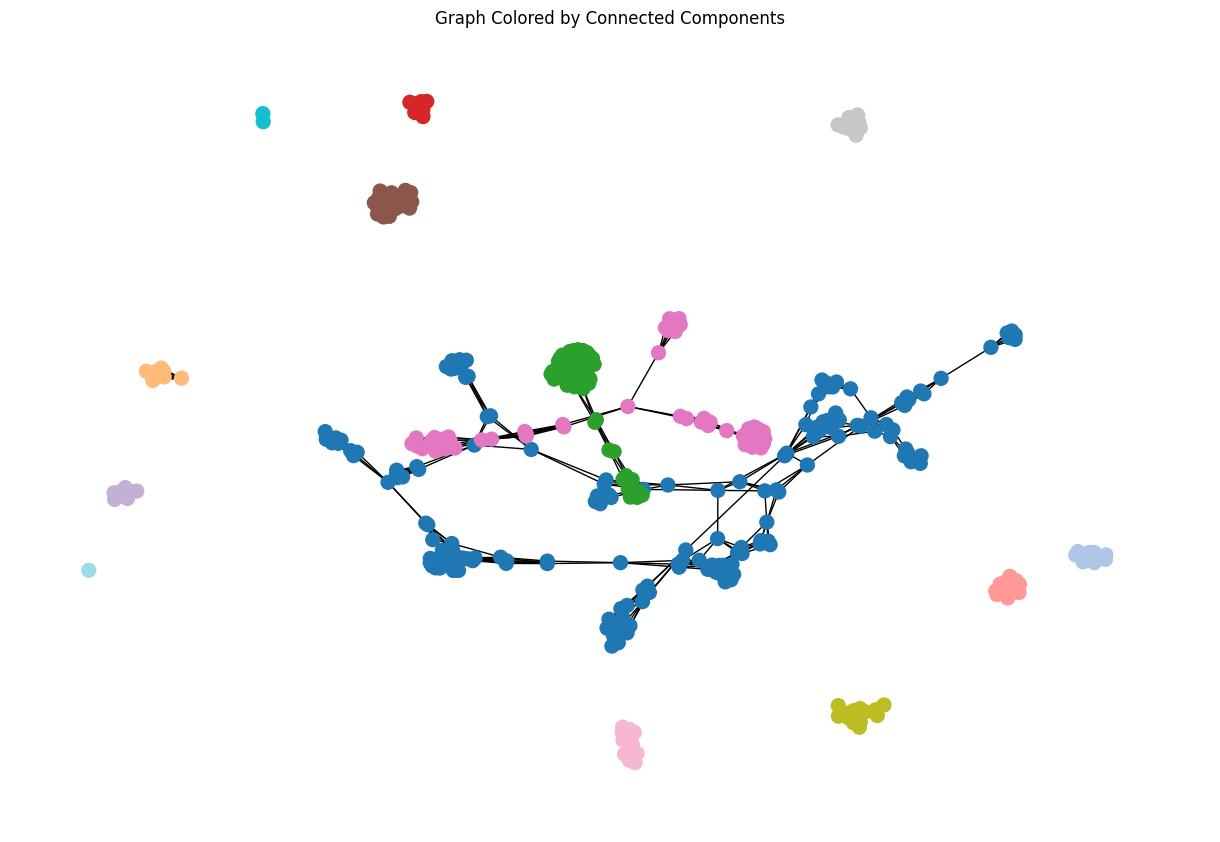


Largest component size: 170
Smallest component size: 1


In [129]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import SpectralClustering
import numpy as np

def visualize_graph(G, title, pos=None, colors=None):
    plt.figure(figsize=(12, 8))

    # If no position is provided, compute layout
    if pos is None:
        pos = nx.spring_layout(G)

    # If no colors provided, color by connected components
    if colors is None:
        components = list(nx.connected_components(G))
        colors = []
        for node in G.nodes():
            for idx, component in enumerate(components):
                if node in component:
                    colors.append(idx)

    # Draw the graph
    nx.draw(G, pos,
           node_color=colors,
           node_size=100,
           cmap=plt.cm.tab20,
           with_labels=False)

    plt.title(title)
    plt.show()

# Visualize connected components
components = list(nx.connected_components(G))
print(f"Number of connected components: {len(components)}")
visualize_graph(G, "Graph Colored by Connected Components")





print("\nLargest component size:", len(max(components, key=len)))
print("Smallest component size:", len(min(components, key=len)))